In [1]:
import pandas as pd
pd.set_option("display.max_columns", None)
from IPython.display import HTML
from IPython.display import display
import numpy as np
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)
import matplotlib.pyplot as plt
import seaborn as sns
import os

from scipy.optimize import curve_fit

from sklearn import preprocessing
from sklearn import metrics
os.chdir("..")
os.getcwd()


'/home/ubuntu/repos/training_dataset_size_per_class'

### Purpose of this notebook: 

# PoC for a multidimensional power law approach for training dataset size prediction.

* Using Cifar10 data
* and a standard cnn architecture
* Varying the number of images per class with different number of overall training dataset sizes
* Collect accuracies for each experiment
* Fit a power law with a linear combination as input.

# statistical models considered:

* ### power law: 
    * Just using last epoch
    * Using all epochs
    * ref: Just using overall training dataset size with last epoch


# Data prep

* reading in csv data
* filter to only keep epochs $>10$
* normalize

Please run `cifar10_datasetsize_multidim.py` before running this notebook.


In [2]:
#results = pd.read_csv("Cifar10_acc_subsets_thomas_batch_size_512_mixture_design_20230628.csv")
results = pd.read_csv("csv_files/Cifar10_acc_subsets_thomas_batch_size_512_mixture_design_maximin_subsetsize_45000_20230705.csv")
results_val = pd.read_csv("csv_files/Cifar10_acc_subsets_thomas_batch_size_512_mixture_design_maximin_subsetsize_45000_val_20230708.csv")
print(results.shape)
results.head(2)

(10800, 13)


,accs,training_times,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epochs_trained
0,0.1006,0.868126,145.0,31.0,97.0,496.0,1096.0,307.0,2382.0,9.0,373.0,63.0,0
1,0.1314,4.390345,145.0,31.0,97.0,496.0,1096.0,307.0,2382.0,9.0,373.0,63.0,5


In [3]:
# Filter data to start with 10 epochs:
# anything below a certain number of epochs seems to be very flaky.
mask = results.epochs_trained >= 10
results = results[mask].reset_index(drop=True)
mask = results_val.epochs_trained >= 10
results_val = results_val[mask].reset_index(drop=True)

In [4]:
classes = results.columns.tolist()[2:12]
print(classes)
results["total_training_size"] = results[classes].sum(axis=1)
results_val["total_training_size"] = results_val[classes].sum(axis=1)
results.head(4)

['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


,accs,training_times,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epochs_trained,total_training_size
0,0.1787,4.370253,145.0,31.0,97.0,496.0,1096.0,307.0,2382.0,9.0,373.0,63.0,10,4999.0
1,0.2051,4.355270,145.0,31.0,97.0,496.0,1096.0,307.0,2382.0,9.0,373.0,63.0,15,4999.0
2,0.2030,4.387133,145.0,31.0,97.0,496.0,1096.0,307.0,2382.0,9.0,373.0,63.0,20,4999.0
3,0.2506,4.299767,145.0,31.0,97.0,496.0,1096.0,307.0,2382.0,9.0,373.0,63.0,25,4999.0


In [5]:
# print out first few rows of generated dataset:
print(results[["accs"] + classes + ["epochs_trained", "total_training_size"]].iloc[:5, :].to_latex(float_format="{:.2f}".format))


\begin{tabular}{lrrrrrrrrrrrrr}
\toprule
{} &  accs &  plane &   car &  bird &    cat &    deer &    dog &    frog &  horse &   ship &  truck &  epochs\_trained &  total\_training\_size \\
\midrule
0 &  0.18 & 145.00 & 31.00 & 97.00 & 496.00 & 1096.00 & 307.00 & 2382.00 &   9.00 & 373.00 &  63.00 &              10 &              4999.00 \\
1 &  0.21 & 145.00 & 31.00 & 97.00 & 496.00 & 1096.00 & 307.00 & 2382.00 &   9.00 & 373.00 &  63.00 &              15 &              4999.00 \\
2 &  0.20 & 145.00 & 31.00 & 97.00 & 496.00 & 1096.00 & 307.00 & 2382.00 &   9.00 & 373.00 &  63.00 &              20 &              4999.00 \\
3 &  0.25 & 145.00 & 31.00 & 97.00 & 496.00 & 1096.00 & 307.00 & 2382.00 &   9.00 & 373.00 &  63.00 &              25 &              4999.00 \\
4 &  0.24 & 145.00 & 31.00 & 97.00 & 496.00 & 1096.00 & 307.00 & 2382.00 &   9.00 & 373.00 &  63.00 &              30 &              4999.00 \\
\bottomrule
\end{tabular}



In [6]:
### constructing a pred dataset: 
#results_pred = 
results_pred = results[["training_times"] + classes + ["epochs_trained", "total_training_size"]].copy()
row = {c: 5000 for c in classes}
row["epochs_trained"] = 195
row["total_training_size"] =  50000
row["training_times"] = 100
results_pred = results_pred.append(row, ignore_index=True)
row = {c: 5000 for c in classes}
row["training_times"] = 100
row["epochs_trained"] = 150
row["total_training_size"] =  50000
results_pred = results_pred.append(row, ignore_index=True)
results_pred = results_pred.iloc[-2:,:].reset_index(drop=True)
for c_5000 in classes:
    row = {c: 4500 for c in classes}
    row[c_5000] = 5000
    row["epochs_trained"] = 195
    row["training_times"] = 100
    row["total_training_size"] =  45500
    results_pred = results_pred.append(row, ignore_index=True)
    row["epochs_trained"] = 150
    results_pred = results_pred.append(row, ignore_index=True)
    row["epochs_trained"] = 100
    results_pred = results_pred.append(row, ignore_index=True)
    row["epochs_trained"] = 50
    results_pred = results_pred.append(row, ignore_index=True)
for c_5000 in classes:
    row = {c: 4000 for c in classes}
    row[c_5000] = 5000
    row["epochs_trained"] = 195
    row["training_times"] = 100
    row["total_training_size"] =  41000
    results_pred = results_pred.append(row, ignore_index=True)
    row["epochs_trained"] = 150
    results_pred = results_pred.append(row, ignore_index=True)
    row["epochs_trained"] = 100
    results_pred = results_pred.append(row, ignore_index=True)
    row["epochs_trained"] = 50
    results_pred = results_pred.append(row, ignore_index=True)
for c_5000 in classes:
    row = {c: 5000 for c in classes}
    row[c_5000] = 7000
    row["epochs_trained"] = 195
    row["training_times"] = 100
    row["total_training_size"] =  52000
    results_pred = results_pred.append(row, ignore_index=True)
    row["epochs_trained"] = 150
    results_pred = results_pred.append(row, ignore_index=True)
    row["epochs_trained"] = 100
    results_pred = results_pred.append(row, ignore_index=True)
    row["epochs_trained"] = 50
    results_pred = results_pred.append(row, ignore_index=True)

results_pred_orig = results_pred.copy()
results_pred

,training_times,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epochs_trained,total_training_size
0,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,195,50000.0
1,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,150,50000.0
2,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,195,45500.0
3,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,150,45500.0
4,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,100,45500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,7000.0,5000.0,50,52000.0
118,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,7000.0,195,52000.0
119,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,7000.0,150,52000.0
120,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,7000.0,100,52000.0


In [7]:
### normalize results:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X = results.iloc[:, 1:])
results_scaled = pd.DataFrame(scaler.transform(results.iloc[:, 1:]))
results_scaled.columns = results.iloc[:, 1:].columns
results = pd.concat([results["accs"], results_scaled], axis=1)
results.head(2)

,accs,training_times,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epochs_trained,total_training_size
0,0.1787,0.004281,0.026474,0.005604,0.017044,0.098679,0.217723,0.060096,0.474814,0.001601,0.074059,0.012402,0.000000,0.000025
1,0.2051,0.003710,0.026474,0.005604,0.017044,0.098679,0.217723,0.060096,0.474814,0.001601,0.074059,0.012402,0.027027,0.000025


In [8]:
# using the same scaler for train and val:
results_scaled_val = pd.DataFrame(scaler.transform(results_val.iloc[:, 1:]))
results_scaled_val.columns = results_val.iloc[:, 1:].columns
results_val = pd.concat([results_val["accs"], results_scaled_val], axis=1)
results_val.head(2)

,accs,training_times,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epochs_trained,total_training_size
0,0.2633,0.005252,0.138187,0.041833,0.040706,0.005404,0.15016,0.019832,0.395143,0.038223,0.151521,0.008002,0.000000,0.0001
1,0.2866,0.009001,0.138187,0.041833,0.040706,0.005404,0.15016,0.019832,0.395143,0.038223,0.151521,0.008002,0.027027,0.0001


In [9]:
# using the same scaler for train and val:
results_scaled_pred = pd.DataFrame(scaler.transform(results_pred))
results_scaled_pred.columns = results_pred.columns
results_pred = results_scaled_pred
results_pred

,training_times,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epochs_trained,total_training_size
0,3.648453,1.000201,1.00020,1.000201,1.00020,1.000401,1.00020,1.000201,1.00040,1.00020,1.00000,1.000000,1.124881
1,3.648453,1.000201,1.00020,1.000201,1.00020,1.000401,1.00020,1.000201,1.00040,1.00020,1.00000,0.756757,1.124881
2,3.648453,1.000201,0.90012,0.899940,0.90012,0.900160,0.90004,0.899860,0.90034,0.90012,0.89998,1.000000,1.012398
3,3.648453,1.000201,0.90012,0.899940,0.90012,0.900160,0.90004,0.899860,0.90034,0.90012,0.89998,0.756757,1.012398
4,3.648453,1.000201,0.90012,0.899940,0.90012,0.900160,0.90004,0.899860,0.90034,0.90012,0.89998,0.486486,1.012398
...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,3.648453,1.000201,1.00020,1.000201,1.00020,1.000401,1.00020,1.000201,1.00040,1.40052,1.00000,0.216216,1.174874
118,3.648453,1.000201,1.00020,1.000201,1.00020,1.000401,1.00020,1.000201,1.00040,1.00020,1.40008,1.000000,1.174874
119,3.648453,1.000201,1.00020,1.000201,1.00020,1.000401,1.00020,1.000201,1.00040,1.00020,1.40008,0.756757,1.174874
120,3.648453,1.000201,1.00020,1.000201,1.00020,1.000401,1.00020,1.000201,1.00040,1.00020,1.40008,0.486486,1.174874


In [10]:
# prep data for using class counts:
xdata = np.transpose(results.to_numpy()[:, 2:-1])
y = results.to_numpy()[:, 0]
xdata_val = np.transpose(results_val.to_numpy()[:, 2:-1])
y_val = results_val.to_numpy()[:, 0]
xdata.shape
xpred = np.transpose(results_pred.to_numpy()[:, 1:-1])
xpred.shape


(11, 122)

In [11]:
# data for last_epoch_training:
mask = results.epochs_trained == 1
results_last_epoch = results[mask].reset_index(drop=True)
xdata_last_epoch = np.transpose(results_last_epoch.to_numpy()[:, 2:-2])
y_last_epoch = results_last_epoch.to_numpy()[:, 0]

mask = results_val.epochs_trained == 1
results_val_last_epoch = results_val[mask].reset_index(drop=True)
xdata_val_last_epoch = np.transpose(results_val_last_epoch.to_numpy()[:, 2:-2])
y_val_last_epoch = results_val_last_epoch.to_numpy()[:, 0]

In [12]:
# data for total_n and epoch only:
xdata_total_n_epoch = np.transpose(results.to_numpy()[:, -2:])
xdata_val_total_n_epoch = np.transpose(results_val.to_numpy()[:, -2:])
xpred_total_n_epoch = np.transpose(results_pred.to_numpy()[:, -2:])
xpred_total_n_epoch.shape

(2, 122)

In [13]:
# data for last epoch, total_n only:
xdata_last_epoch_total_n = np.transpose(results_last_epoch.to_numpy()[:, -1:])
xdata_val_last_epoch_total_n = np.transpose(results_val_last_epoch.to_numpy()[:, -1:])
xdata_last_epoch_total_n.shape

(1, 270)

In [14]:
# some plotting parameters
props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# powerlaw - full linear option

### Full option: 

* Fit a power law model, having the count of each level as input ... 
* ... and the number of epochs as an input as well.

param_name,a,b,c,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epoch
param_value,-0.051922,0.404459,0.474132,0.540846,0.451075,0.430359,0.246295,0.437081,0.396777,0.42874,0.543736,0.330192,0.362537,0.867388


\begin{tabular}{lrrrrrrrrrrrrrr}
\toprule
param\_name &     a &    b &    c &  plane &  car &  bird &  cat &  deer &  dog &  frog &  horse &  ship &  truck &  epoch \\
\midrule
param\_value & -0.05 & 0.40 & 0.47 &   0.54 & 0.45 &  0.43 & 0.25 &  0.44 & 0.40 &  0.43 &   0.54 &  0.33 &   0.36 &   0.87 \\
\bottomrule
\end{tabular}

0.0025171914300640445


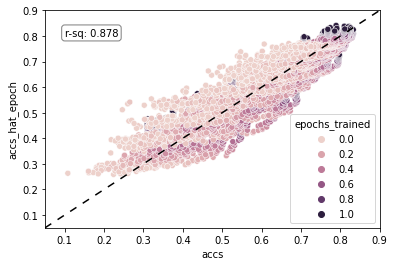

0.8776119153005251
mean val loss: 0.0026261666655722233


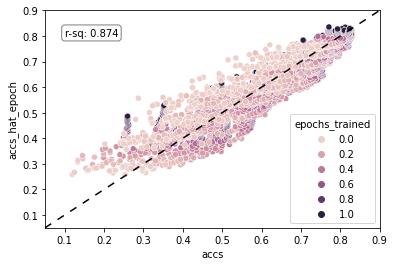

r_square val: 0.8738956779220979


In [15]:
def func_powerlaw_exponent_epoch(x, a: float, b: float, c: float, d0:float, d1:float, d2:float, d3:float, d4:float, d5:float, d6:float, d7:float, d8:float, d9:float, d_epochs:float) -> float:
    x0 = x[0]
    x1 = x[1]
    x2 = x[2]
    x3 = x[3]
    x4 = x[4]
    x5 = x[5]
    x6 = x[6]
    x7 = x[7]
    x8 = x[8]
    x9 = x[9]
    epochs_trained = x[10]
    return a + ((d0*x0 + d1*x1 + d2*x2 + d3*x3 + d4*x4 + d5*x5 + d6*x6 + d7*x7 + d8*x8 + d9*x9 + d_epochs*epochs_trained)**b) * c

np.random.seed(seed=4213523)
p0 = np.random.uniform(low=0, high=1, size = 14)
converged = False
try:
    params, params_cov = curve_fit(func_powerlaw_exponent_epoch, xdata, y, maxfev=200000, p0=p0, bounds=(-10, 10))
    converged = True
except:
    print("did not converge")

if converged:
    param_names = ["a", "b", "c"]
    param_names = param_names + classes + ["epoch"]
    param_df = pd.DataFrame({"param_name": param_names, "param_value": params})
    param_df = param_df.set_index("param_name").T
    HTML(display(param_df))
    print(param_df.to_latex(float_format="{:.2f}".format))
    y_hat_name = "accs_hat_epoch"
    y_hat = func_powerlaw_exponent_epoch(xdata, *params)
    print(((y_hat - y)**2).mean())
    # dataframe for plotting:
    results[y_hat_name] = y_hat

    sns.scatterplot(data = results, x="accs", y = y_hat_name, hue = "epochs_trained")
    plt.xlim((0.05, 0.9))
    plt.ylim((0.05, 0.9))
    plt.axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
    plt.text(x=0.1, y=0.8, s=f"r-sq: {np.round(metrics.r2_score(results.accs, results[y_hat_name]), 3)}", bbox=props)
    plt.savefig(f"paper/plots/powerlaw_train_{y_hat_name}.jpg")
    plt.show()
    print(metrics.r2_score(results.accs, results[y_hat_name]))
    # val data:
    y_val_hat = func_powerlaw_exponent_epoch(xdata_val, *params)
    print(f"mean val loss: {((y_val_hat - y_val)**2).mean()}")
    # dataframe for plotting:
    results_val[y_hat_name] = y_val_hat

    sns.scatterplot(data = results_val, x="accs", y = y_hat_name, hue = "epochs_trained")
    plt.xlim((0.05, 0.9))
    plt.ylim((0.05, 0.9))
    plt.axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
    plt.text(x=0.1, y=0.8, s=f"r-sq: {np.round(metrics.r2_score(results_val.accs, results_val[y_hat_name]), 3)}", bbox=props)
    plt.savefig(f"paper/plots/powerlaw_val_{y_hat_name}.jpg")
    plt.show()

    print(f"r_square val: {metrics.r2_score(results_val.accs, results_val[y_hat_name])}")

### Using an arctan effect for epoch only, but linear for classes:

param_name,a,b,c,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epoch,epoch_2
param_value,-0.249172,0.402279,0.437909,0.959484,0.838402,0.784056,0.47087,0.808785,0.721452,0.792294,0.986161,0.611369,0.677852,1.567354,8.974194


\begin{tabular}{lrrrrrrrrrrrrrrr}
\toprule
param\_name &     a &    b &    c &  plane &  car &  bird &  cat &  deer &  dog &  frog &  horse &  ship &  truck &  epoch &  epoch\_2 \\
\midrule
param\_value & -0.25 & 0.40 & 0.44 &   0.96 & 0.84 &  0.78 & 0.47 &  0.81 & 0.72 &  0.79 &   0.99 &  0.61 &   0.68 &   1.57 &     8.97 \\
\bottomrule
\end{tabular}

0.001892104296599866


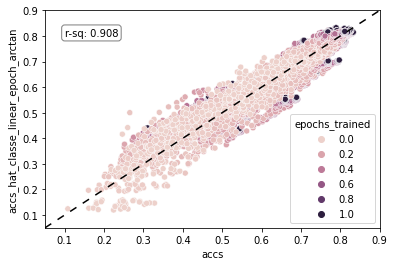

0.9080042073293516
mean val loss: 0.001968294245545514


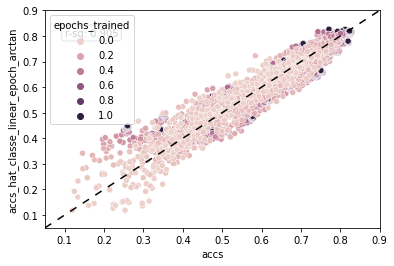

r_square val: 0.9054856591021919


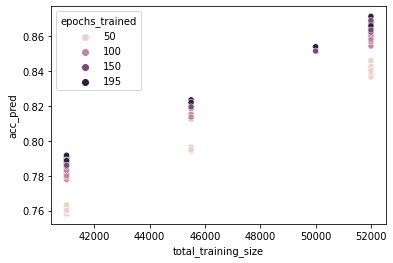

,training_times,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epochs_trained,total_training_size,acc_pred
0,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,195,50000.0,0.853942
1,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,150,50000.0,0.851473
2,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,195,45500.0,0.823401
3,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,150,45500.0,0.820827
4,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,100,45500.0,0.815022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,7000.0,5000.0,50,52000.0,0.839190
118,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,7000.0,195,52000.0,0.865951
119,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,7000.0,150,52000.0,0.863522
120,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,7000.0,100,52000.0,0.858047


In [16]:
def func_powerlaw(x, a: float, b: float, c: float, d0:float, d1:float, d2:float, d3:float, d4:float, d5:float, d6:float, d7:float, d8:float, d9:float, d_epochs:float, d_epoch_2:float) -> float:
    x0 = x[0]
    x1 = x[1]
    x2 = x[2]
    x3 = x[3]
    x4 = x[4]
    x5 = x[5]
    x6 = x[6]
    x7 = x[7]
    x8 = x[8]
    x9 = x[9]
    epochs_trained = x[10]
    return a + ((d0*x0 + d1*x1 + d2*x2 + d3*x3 + d4*x4 + d5*x5 + d6*x6 + d7*x7 + d8*x8 + d9*x9 + d_epochs*np.arctan(d_epoch_2 * epochs_trained))**b) * c

np.random.seed(seed=42135230)
p0 = np.random.uniform(low=0, high=1, size = 15)
converged = False
try:
    params, params_cov = curve_fit(func_powerlaw, xdata, y, maxfev=200000, p0=p0, bounds=(-10, 10))
    converged = True
except:
    print("did not converge")


if converged:
    param_names = ["a", "b", "c"]
    param_names = param_names + classes + ["epoch", "epoch_2"]
    param_df = pd.DataFrame({"param_name": param_names, "param_value": params})
    param_df = param_df.set_index("param_name").T
    HTML(display(param_df))
    print(param_df.to_latex(float_format="{:.2f}".format))
    y_hat_name = "accs_hat_classe_linear_epoch_arctan"
    y_hat = func_powerlaw(xdata, *params)
    print(((y_hat - y)**2).mean())
    # dataframe for plotting:
    results[y_hat_name] = y_hat

    sns.scatterplot(data = results, x="accs", y = y_hat_name, hue = "epochs_trained")
    plt.xlim((0.05, 0.9))
    plt.ylim((0.05, 0.9))
    plt.axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
    plt.text(x=0.1, y=0.8, s=f"r-sq: {np.round(metrics.r2_score(results.accs, results[y_hat_name]), 3)}", bbox=props)
    plt.savefig(f"paper/plots/powerlaw_train_{y_hat_name}.jpg")
    plt.show()
    print(metrics.r2_score(results.accs, results[y_hat_name]))
    # val data:
    y_val_hat = func_powerlaw(xdata_val, *params)
    print(f"mean val loss: {((y_val_hat - y_val)**2).mean()}")
    # dataframe for plotting:
    results_val[y_hat_name] = y_val_hat

    sns.scatterplot(data = results_val, x="accs", y = y_hat_name, hue = "epochs_trained")
    plt.xlim((0.05, 0.9))
    plt.ylim((0.05, 0.9))
    plt.axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
    plt.text(x=0.1, y=0.8, s=f"r-sq: {np.round(metrics.r2_score(results_val.accs, results_val[y_hat_name]), 3)}", bbox=props)
    plt.savefig(f"paper/plots/powerlaw_val_{y_hat_name}.jpg")
    plt.show()

    print(f"r_square val: {metrics.r2_score(results_val.accs, results_val[y_hat_name])}")

    acc_pred = func_powerlaw(xpred, *params)
    results_pred_orig["acc_pred"] = acc_pred
    sns.scatterplot(data = results_pred_orig, x = "total_training_size", y = "acc_pred", hue="epochs_trained")
    plt.show()
    display(results_pred_orig)

### using an arctan effect for every class:

param_name,a,b,c,plane_1,plane_2,car_1,car_2,bird_1,bird_2,cat_1,cat_2,deer_1,deer_2,dog_1,dog_2,frog_1,frog_2,horse_1,horse_2,ship_1,ship_2,truck_1,truck_2,epoch_1,epoch_2
param_value,0.062505,1.256439,0.043404,0.569663,8.845893,0.63168,14.276748,0.502889,6.592162,0.349514,5.142911,0.551914,3.546163,0.439231,4.434329,0.561291,9.356227,0.643931,11.303404,0.607077,16.687615,0.533304,15.935723,1.40125,12.065159


\begin{tabular}{lrrrrrrrrrrrrrrrrrrrrrrrrr}
\toprule
param\_name &    a &    b &    c &  plane\_1 &  plane\_2 &  car\_1 &  car\_2 &  bird\_1 &  bird\_2 &  cat\_1 &  cat\_2 &  deer\_1 &  deer\_2 &  dog\_1 &  dog\_2 &  frog\_1 &  frog\_2 &  horse\_1 &  horse\_2 &  ship\_1 &  ship\_2 &  truck\_1 &  truck\_2 &  epoch\_1 &  epoch\_2 \\
\midrule
param\_value & 0.06 & 1.26 & 0.04 &     0.57 &     8.85 &   0.63 &  14.28 &    0.50 &    6.59 &   0.35 &   5.14 &    0.55 &    3.55 &   0.44 &   4.43 &    0.56 &    9.36 &     0.64 &    11.30 &    0.61 &   16.69 &     0.53 &    15.94 &     1.40 &    12.07 \\
\bottomrule
\end{tabular}

0.0006040751406732345


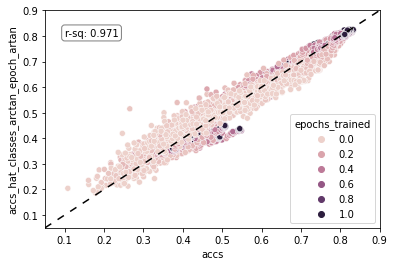

0.9706293297368798
0.9705575819592193
mean val loss: 0.0006621126976100224


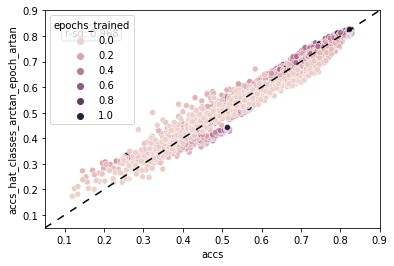

r_square val: 0.9682064074737275
0.9680506786702093


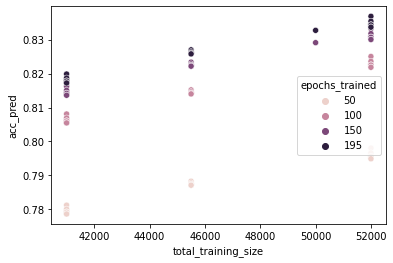

,training_times,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epochs_trained,total_training_size,acc_pred
0,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,195,50000.0,0.832727
1,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,150,50000.0,0.829101
2,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,195,45500.0,0.826124
3,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,150,45500.0,0.822505
4,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,100,45500.0,0.814336
5,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,50,45500.0,0.787450
6,100.0,4500.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,195,45500.0,0.825911
7,100.0,4500.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,150,45500.0,0.822291
8,100.0,4500.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,100,45500.0,0.814123
9,100.0,4500.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,50,45500.0,0.787239


param_value           
param_no           1          2
feature                        
bird        0.502889   6.592162
car         0.631680  14.276748
cat         0.349514   5.142911
deer        0.551914   3.546163
dog         0.439231   4.434329
epoch       1.401250  12.065159
frog        0.561291   9.356227
horse       0.643931  11.303404
plane       0.569663   8.845893
ship        0.607077  16.687615
truck       0.533304  15.935723

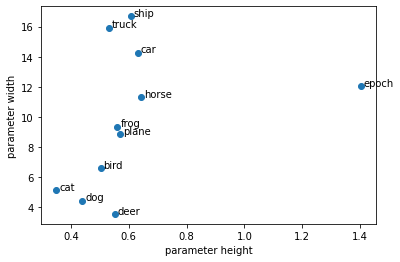

In [17]:
def func_powerlaw(x, a: float, b: float, c: float, d0:float, d0_2:float, d1:float, d1_2:float, d2:float, d2_2:float, d3:float, d3_2:float, d4:float, d4_2:float, d5:float, d5_2:float, d6:float, d6_2:float, d7:float, d7_2:float, d8:float, d8_2:float, d9:float, d9_2:float, d_epochs:float, d_epoch_2:float) -> float:
    x0 = x[0]
    x1 = x[1]
    x2 = x[2]
    x3 = x[3]
    x4 = x[4]
    x5 = x[5]
    x6 = x[6]
    x7 = x[7]
    x8 = x[8]
    x9 = x[9]
    epochs_trained = x[10]
    return a + ((d0* np.arctan(d0_2 * x0) + d1* np.arctan(d1_2 * x1)  + d2* np.arctan(d2_2 * x2) + d3 * np.arctan(d3_2 * x3) + d4 * np.arctan(d4_2 * x4) + d5 * np.arctan(d5_2 * x5) + d6 * np.arctan(d6_2 * x6) + d7 * np.arctan(d7_2 * x7) + d8 * np.arctan(d8_2 * x8) + d9 * np.arctan(d9_2 * x9) + d_epochs*np.arctan(d_epoch_2 * epochs_trained))**b) * c

np.random.seed(seed=42135230)
n_p = 25
p0 = np.random.uniform(low=0, high=1, size = n_p)
converged = False
try:
    params, params_cov = curve_fit(func_powerlaw, xdata, y, maxfev=200000, p0=p0, bounds=(-10, 50))
    converged = True
except:
    print("did not converge")


if converged:
    param_names = ["a", "b", "c"]
    for c in classes:
        param_names = param_names + [f"{c}_1", f"{c}_2"]
    param_names = param_names + ["epoch_1", "epoch_2"]
    param_df = pd.DataFrame({"param_name": param_names, "param_value": params})
    param_df = param_df.set_index("param_name").T
    HTML(display(param_df))
    print(param_df.to_latex(float_format="{:.2f}".format))
    y_hat_name = "accs_hat_classes_arctan_epoch_artan"
    y_hat = func_powerlaw(xdata, *params)
    print(((y_hat - y)**2).mean())
    # dataframe for plotting:
    results[y_hat_name] = y_hat

    sns.scatterplot(data = results, x="accs", y = y_hat_name, hue = "epochs_trained")
    plt.xlim((0.05, 0.9))
    plt.ylim((0.05, 0.9))
    plt.axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
    plt.text(x=0.1, y=0.8, s=f"r-sq: {np.round(metrics.r2_score(results.accs, results[y_hat_name]), 3)}", bbox=props)
    plt.savefig(f"paper/plots/powerlaw_train_{y_hat_name}.jpg")
    plt.show()
    print(metrics.r2_score(results.accs, results[y_hat_name]))
    print(1 - (1 - metrics.r2_score(results.accs, results[y_hat_name])) * (xdata.shape[1] - 1) / (xdata.shape[1] - n_p - 1))
    # val data:
    y_val_hat = func_powerlaw(xdata_val, *params)
    print(f"mean val loss: {((y_val_hat - y_val)**2).mean()}")
    # dataframe for plotting:
    results_val[y_hat_name] = y_val_hat

    sns.scatterplot(data = results_val, x="accs", y = y_hat_name, hue = "epochs_trained")
    plt.xlim((0.05, 0.9))
    plt.ylim((0.05, 0.9))
    plt.axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
    plt.text(x=0.1, y=0.8, s=f"r-sq: {np.round(metrics.r2_score(results_val.accs, results_val[y_hat_name]), 3)}", bbox=props)
    plt.savefig(f"paper/plots/powerlaw_val_{y_hat_name}.jpg")
    plt.show()

    print(f"r_square val: {metrics.r2_score(results_val.accs, results_val[y_hat_name])}")
    print(1 - (1 - metrics.r2_score(results_val.accs, results_val[y_hat_name])) * (xdata_val.shape[1] - 1) / (xdata_val.shape[1] - n_p - 1))
    # Doing different prediction scenarios for accuracy:

    acc_pred = func_powerlaw(xpred, *params)
    results_pred_orig["acc_pred"] = acc_pred
    sns.scatterplot(data = results_pred_orig, x = "total_training_size", y = "acc_pred", hue="epochs_trained")
    plt.show()
    display(results_pred_orig.head(30))
    #param_df.T.reset_index(drop=False).iloc[3:,:]
    param_unstacked = param_df.T.reset_index(drop=False).iloc[3:,:].param_name.str.split("_", expand=True).reset_index(drop=True)
    param_unstacked.columns = ["feature", "param_no"]
    param_unstacked["param_value"] = param_df.T.reset_index(drop=False).iloc[3:,:].reset_index(drop=True).param_value
    param_unstacked = param_unstacked.set_index(["feature", "param_no"])
    param_unstacked = param_unstacked.unstack()
    display(param_unstacked)

    param_unstacked.iloc[:,1]
    plt.scatter(param_unstacked.iloc[:,0], param_unstacked.iloc[:,1])
    plt.xlabel("parameter height")
    plt.ylabel("parameter width")
    for i in range(param_unstacked.shape[0]):
        plt.annotate(param_unstacked.reset_index().iloc[i,0], (param_unstacked.iloc[i,0] + 0.01, param_unstacked.iloc[i, 1]))
    plt.savefig(f"paper/plots/powerlaw_{y_hat_name}_param1_vs_param2.jpg")
    plt.show()


In [18]:
# # the following would be an even strong generalization, however, this does not provide actual benefits in fitting (but takes around 11 minutes to fit)

# def func_powerlaw(x, a: float, b: float, c: float, d0:float, d0_2:float, d0_3:float, d1:float, d1_2:float, d1_3:float, d2:float, d2_2:float, d2_3:float, d3:float, d3_2:float, d3_3:float, d4:float, d4_2:float, d4_3:float, d5:float, d5_2:float, d5_3:float, d6:float, d6_2:float, d6_3:float, d7:float, d7_2:float, d7_3:float, d8:float, d8_2:float, d8_3:float, d9:float, d9_2:float, d9_3:float, d_epochs:float, d_epoch_2:float, d_epoch_3:float) -> float:
#     x0 = x[0]
#     x1 = x[1]
#     x2 = x[2]
#     x3 = x[3]
#     x4 = x[4]
#     x5 = x[5]
#     x6 = x[6]
#     x7 = x[7]
#     x8 = x[8]
#     x9 = x[9]
#     epochs_trained = x[10]
#     return a + ((d0* np.arctan(d0_2 * x0 + d0_3) + d1* np.arctan(d1_2 * x1 + d1_3)  + d2* np.arctan(d2_2 * x2 + d2_3) + d3 * np.arctan(d3_2 * x3 + d3_3) + d4 * np.arctan(d4_2 * x4 + d4_3) + d5 * np.arctan(d5_2 * x5 + d5_3) + d6 * np.arctan(d6_2 * x6 + d6_3) + d7 * np.arctan(d7_2 * x7 + d7_3) + d8 * np.arctan(d8_2 * x8 + d8_3) + d9 * np.arctan(d9_2 * x9 + d9_3) + d_epochs*np.arctan(d_epoch_2 * epochs_trained + d_epoch_3))**b) * c

# np.random.seed(seed=42130)
# n_p = 36
# p0 = np.random.uniform(low=0, high=1, size = n_p)
# converged = False
# try:
#     params, params_cov = curve_fit(func_powerlaw, xdata, y, maxfev=200000, p0=p0, bounds=(-10, 10))
#     converged = True
# except:
#     print("did not converge")


# if converged:
#     param_names = ["a", "b", "c"]
#     for c in classes:
#         param_names = param_names + [c, f"{c}_2", f"{c}_3"]
#     param_names = param_names + ["epoch", "epoch_2"]
#     param_df = pd.DataFrame({"param_name": param_names, "param_value": params})
#     param_df = param_df.set_index("param_name").T
#     HTML(display(param_df))
#     print(param_df.to_latex(float_format="{:.2f}".format))
#     y_hat_name = "accs_hat_epoch_log"
#     y_hat = func_powerlaw(xdata, *params)
#     print(((y_hat - y)**2).mean())
#     # dataframe for plotting:
#     results[y_hat_name] = y_hat

#     sns.scatterplot(data = results, x="accs", y = y_hat_name, hue = "epochs_trained")
#     plt.xlim((0.05, 0.9))
#     plt.ylim((0.05, 0.9))
#     plt.axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
#     plt.text(x=0.1, y=0.8, s=f"r-sq: {np.round(metrics.r2_score(results.accs, results[y_hat_name]), 3)}", bbox=props)
#     plt.savefig(f"paper/plots/powerlaw_train_{y_hat_name}.jpg")
#     plt.show()
#     print(metrics.r2_score(results.accs, results[y_hat_name]))
#     print(1 - (1 - metrics.r2_score(results.accs, results[y_hat_name])) * (xdata.shape[1] - 1) / (xdata.shape[1] - n_p - 1))
#     # val data:
#     y_val_hat = func_powerlaw(xdata_val, *params)
#     print(f"mean val loss: {((y_val_hat - y_val)**2).mean()}")
#     # dataframe for plotting:
#     results_val[y_hat_name] = y_val_hat

#     sns.scatterplot(data = results_val, x="accs", y = y_hat_name, hue = "epochs_trained")
#     plt.xlim((0.05, 0.9))
#     plt.ylim((0.05, 0.9))
#     plt.axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
#     plt.text(x=0.1, y=0.8, s=f"r-sq: {np.round(metrics.r2_score(results_val.accs, results_val[y_hat_name]), 3)}", bbox=props)
#     plt.savefig(f"paper/plots/powerlaw_val_{y_hat_name}.jpg")
#     plt.show()

#     print(f"r_square val: {metrics.r2_score(results_val.accs, results_val[y_hat_name])}")
#     print(1 - (1 - metrics.r2_score(results_val.accs, results_val[y_hat_name])) * (xdata_val.shape[1] - 1) / (xdata_val.shape[1] - n_p - 1))

# all class counts linear, but including quadratic term for epoch:

[-0.17581021  0.39408561  0.6839999   0.28771196  0.24647907  0.23229695
  0.13680231  0.23805391  0.21394657  0.23354509  0.29339638  0.1803655
  0.19841878  1.6118413  -1.17281273]


param_name,a,b,c,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epoch,epoch**2
param_value,-0.17581,0.394086,0.684,0.287712,0.246479,0.232297,0.136802,0.238054,0.213947,0.233545,0.293396,0.180365,0.198419,1.611841,-1.172813


\begin{tabular}{lrrrrrrrrrrrrrrr}
\toprule
param\_name &     a &    b &    c &  plane &  car &  bird &  cat &  deer &  dog &  frog &  horse &  ship &  truck &  epoch &  epoch**2 \\
\midrule
param\_value & -0.18 & 0.39 & 0.68 &   0.29 & 0.25 &  0.23 & 0.14 &  0.24 & 0.21 &  0.23 &   0.29 &  0.18 &   0.20 &   1.61 &     -1.17 \\
\bottomrule
\end{tabular}

train avg loss:
0.0020301461103532756


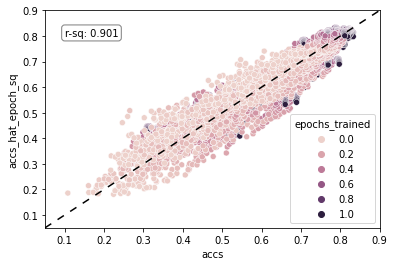

rsquare train:
0.9012924916481602
0.901147957030308
val avg loss:
0.0021192189063168588


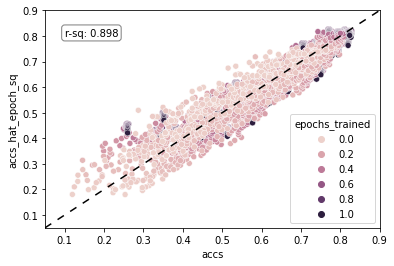

rsquare val:
0.8982384983332615
0.8979400191535585


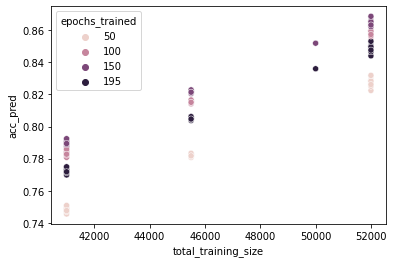

,training_times,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epochs_trained,total_training_size,acc_pred
0,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,195,50000.0,0.835970
1,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,150,50000.0,0.851884
2,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,195,45500.0,0.806117
3,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,150,45500.0,0.822766
4,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,100,45500.0,0.816475
5,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,50,45500.0,0.783237
6,100.0,4500.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,195,45500.0,0.805470
7,100.0,4500.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,150,45500.0,0.822135
8,100.0,4500.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,100,45500.0,0.815838
9,100.0,4500.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,50,45500.0,0.782566


In [19]:
def func_powerlaw(x, a: float, b: float, c: float, d0:float, d1:float, d2:float, d3:float, d4:float, d5:float, d6:float, d7:float, d8:float, d9:float, d_epochs:float, d_epochs_sq:float) -> float:
    x0 = x[0]
    x1 = x[1]
    x2 = x[2]
    x3 = x[3]
    x4 = x[4]
    x5 = x[5]
    x6 = x[6]
    x7 = x[7]
    x8 = x[8]
    x9 = x[9]
    epochs_trained = x[10]
    return a + ((d0*x0 + d1*x1 + d2*x2 + d3*x3 + d4*x4 + d5*x5 + d6*x6 + d7*x7 + d8*x8 + d9*x9 + d_epochs*epochs_trained + d_epochs_sq * epochs_trained**2)**b) * c

np.random.seed(seed=421324576)
n_p = 15
p0 = np.random.uniform(low=0, high=1, size = n_p)
converged = False
try:
    params, params_cov = curve_fit(func_powerlaw, xdata, y, maxfev=200000, p0=p0, bounds=(-10, 10))
    converged = True
except:
    print("did not converge")

if converged:
    print(params)
    param_names = ["a", "b", "c"]
    param_names = param_names + classes + ["epoch", "epoch**2"]
    param_df = pd.DataFrame({"param_name": param_names, "param_value": params})
    param_df = param_df.set_index("param_name").T
    HTML(display(param_df))
    print(param_df.to_latex(float_format="{:.2f}".format))
    y_hat_name = "accs_hat_epoch_sq"
    y_hat = func_powerlaw(xdata, *params)
    print("train avg loss:")
    print(((y_hat - y)**2).mean())
    # dataframe for plotting:
    results[y_hat_name] = y_hat
    sns.scatterplot(data = results, x="accs", y = y_hat_name, hue = "epochs_trained")
    plt.xlim((0.05, 0.9))
    plt.ylim((0.05, 0.9))
    plt.axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
    plt.text(x=0.1, y=0.8, s=f"r-sq: {np.round(metrics.r2_score(results.accs, results[y_hat_name]), 3)}", bbox=props)
    plt.savefig(f"paper/plots/powerlaw_train_{y_hat_name}.jpg")
    plt.show()
    print("rsquare train:")
    print(metrics.r2_score(results.accs, results[y_hat_name]))
    print(1 - (1 - metrics.r2_score(results.accs, results[y_hat_name])) * (xdata.shape[1] - 1) / (xdata.shape[1] - n_p - 1))
    # val data:
    y_val_hat = func_powerlaw(xdata_val, *params)
    print("val avg loss:")
    print(((y_val_hat - y_val)**2).mean())
    # dataframe for plotting:
    results_val[y_hat_name] = y_val_hat

    sns.scatterplot(data = results_val, x="accs", y = y_hat_name, hue = "epochs_trained")
    plt.xlim((0.05, 0.9))
    plt.ylim((0.05, 0.9))
    plt.axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
    plt.text(x=0.1, y=0.8, s=f"r-sq: {np.round(metrics.r2_score(results_val.accs, results_val[y_hat_name]), 3)}", bbox=props)
    plt.savefig(f"paper/plots/powerlaw_val_{y_hat_name}.jpg")
    plt.show()
    print("rsquare val:")
    print(metrics.r2_score(results_val.accs, results_val[y_hat_name]))
    print(1 - (1 - metrics.r2_score(results_val.accs, results_val[y_hat_name])) * (xdata_val.shape[1] - 1) / (xdata_val.shape[1] - n_p - 1))

    acc_pred = func_powerlaw(xpred, *params)
    results_pred_orig["acc_pred"] = acc_pred
    sns.scatterplot(data = results_pred_orig, x = "total_training_size", y = "acc_pred", hue="epochs_trained")
    plt.show()
    display(results_pred_orig.head(30))



# Adding an intercept to the linear combination (keeping the squared epoch):

/tmp/ipykernel_35943/3781602169.py:13: RuntimeWarning: invalid value encountered in power
  return a + ((d_int + d0*x0 + d1*x1 + d2*x2 + d3*x3 + d4*x4 + d5*x5 + d6*x6 + d7*x7 + d8*x8 + d9*x9 + d_epochs*epochs_trained + d_epochs_sq * epochs_trained**2)**b) * c


param_name,a,b,c,intercept,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epoch,epoch**2
param_value,-9.999999,0.042716,9.701275,2.484782,1.143048,0.974346,0.920157,0.540252,0.947793,0.851447,0.921425,1.170033,0.7183,0.781551,6.509159,-4.741976


\begin{tabular}{lrrrrrrrrrrrrrrrr}
\toprule
param\_name &      a &    b &    c &  intercept &  plane &  car &  bird &  cat &  deer &  dog &  frog &  horse &  ship &  truck &  epoch &  epoch**2 \\
\midrule
param\_value & -10.00 & 0.04 & 9.70 &       2.48 &   1.14 & 0.97 &  0.92 & 0.54 &  0.95 & 0.85 &  0.92 &   1.17 &  0.72 &   0.78 &   6.51 &     -4.74 \\
\bottomrule
\end{tabular}

train avg loss:
0.002006555510032147


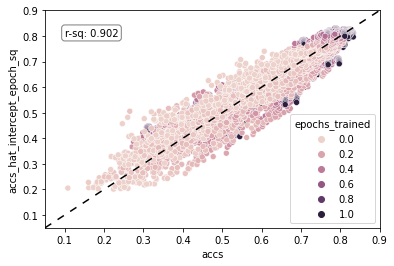

rsquare train:
0.9024394876039427
val avg loss:
0.0021035147490532126


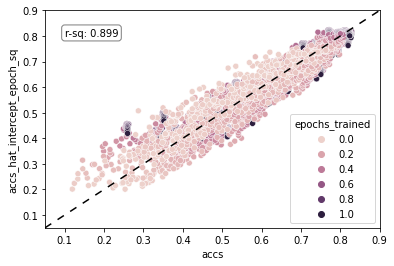

rsquare val:
0.8989925868423796


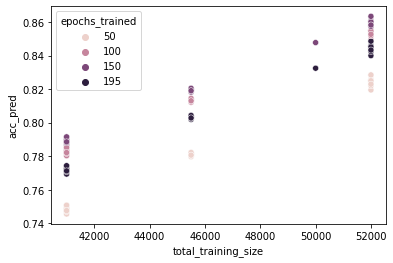

,training_times,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epochs_trained,total_training_size,acc_pred
0,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,195,50000.0,0.832453
1,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,150,50000.0,0.847713
2,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,195,45500.0,0.804217
3,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,150,45500.0,0.820381
4,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,100,45500.0,0.814392
5,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,50,45500.0,0.782144
6,100.0,4500.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,195,45500.0,0.803582
7,100.0,4500.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,150,45500.0,0.819766
8,100.0,4500.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,100,45500.0,0.813770
9,100.0,4500.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,50,45500.0,0.781479


In [20]:
def func_powerlaw(x, a: float, b: float, c: float, d_int:float, d0:float, d1:float, d2:float, d3:float, d4:float, d5:float, d6:float, d7:float, d8:float, d9:float, d_epochs:float, d_epochs_sq:float) -> float:
    x0 = x[0]
    x1 = x[1]
    x2 = x[2]
    x3 = x[3]
    x4 = x[4]
    x5 = x[5]
    x6 = x[6]
    x7 = x[7]
    x8 = x[8]
    x9 = x[9]
    epochs_trained = x[10]
    return a + ((d_int + d0*x0 + d1*x1 + d2*x2 + d3*x3 + d4*x4 + d5*x5 + d6*x6 + d7*x7 + d8*x8 + d9*x9 + d_epochs*epochs_trained + d_epochs_sq * epochs_trained**2)**b) * c

np.random.seed(seed=91240912)
p0 = np.random.uniform(low=0, high=1, size = 16)
converged = False
try:
    params, params_cov = curve_fit(func_powerlaw, xdata, y, maxfev=200000, p0=p0, bounds=(-10, 10))
    converged = True
except:
    print("did not converge")

if converged:
    param_names = ["a", "b", "c", "intercept"]
    param_names = param_names + classes + ["epoch", "epoch**2"]
    param_df = pd.DataFrame({"param_name": param_names, "param_value": params})
    param_df = param_df.set_index("param_name").T
    HTML(display(param_df))
    print(param_df.to_latex(float_format="{:.2f}".format))
    y_hat_name = "accs_hat_intercept_epoch_sq"
    y_hat = func_powerlaw(xdata, *params)
    print("train avg loss:")
    print(((y_hat - y)**2).mean())
    # dataframe for plotting:
    results[y_hat_name] = y_hat
    sns.scatterplot(data = results, x="accs", y = y_hat_name, hue = "epochs_trained")
    plt.xlim((0.05, 0.9))
    plt.ylim((0.05, 0.9))
    plt.axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
    plt.text(x=0.1, y=0.8, s=f"r-sq: {np.round(metrics.r2_score(results.accs, results[y_hat_name]), 3)}", bbox=props)
    plt.savefig(f"paper/plots/powerlaw_train_{y_hat_name}.jpg")
    plt.show()
    print("rsquare train:")
    print(metrics.r2_score(results.accs, results[y_hat_name]))
    # val data:
    y_val_hat = func_powerlaw(xdata_val, *params)
    print("val avg loss:")
    print(((y_val_hat - y_val)**2).mean())
    # dataframe for plotting:
    results_val[y_hat_name] = y_val_hat

    sns.scatterplot(data = results_val, x="accs", y = y_hat_name, hue = "epochs_trained")
    plt.xlim((0.05, 0.9))
    plt.ylim((0.05, 0.9))
    plt.axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
    plt.text(x=0.1, y=0.8, s=f"r-sq: {np.round(metrics.r2_score(results_val.accs, results_val[y_hat_name]), 3)}", bbox=props)
    plt.savefig(f"paper/plots/powerlaw_val_{y_hat_name}.jpg")
    plt.show()
    print("rsquare val:")
    print(metrics.r2_score(results_val.accs, results_val[y_hat_name]))

    acc_pred = func_powerlaw(xpred, *params)
    results_pred_orig["acc_pred"] = acc_pred
    sns.scatterplot(data = results_pred_orig, x = "total_training_size", y = "acc_pred", hue="epochs_trained")
    plt.show()
    display(results_pred_orig.head(30))

# using all epochs, but just overall training dataset size:

param_name,a,b,c,total_n,epoch
param_value,0.248457,0.607865,0.826553,0.116847,0.451516


\begin{tabular}{lrrrrr}
\toprule
param\_name &    a &    b &    c &  total\_n &  epoch \\
\midrule
param\_value & 0.25 & 0.61 & 0.83 &     0.12 &   0.45 \\
\bottomrule
\end{tabular}

train avg loss:
0.0026239617475040194


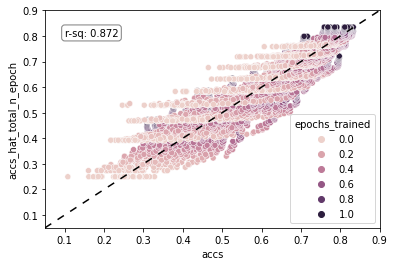

rsquare train:
0.8724206475653171
val avg loss:
0.0025158441160198193


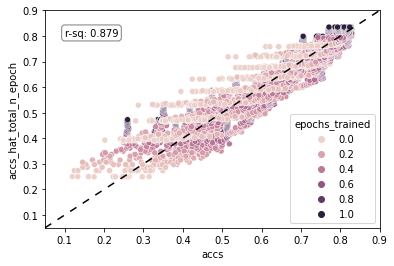

rsquare val:
0.87919319026341


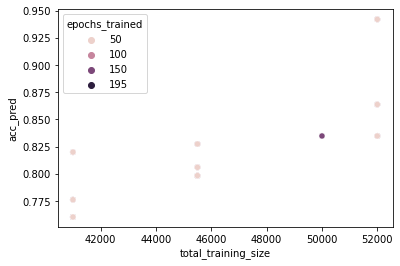

,training_times,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epochs_trained,total_training_size,acc_pred
0,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,195,50000.0,0.834823
1,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,150,50000.0,0.834823
2,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,195,45500.0,0.806032
3,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,150,45500.0,0.806032
4,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,100,45500.0,0.806032
5,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,50,45500.0,0.806032
6,100.0,4500.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,195,45500.0,0.827446
7,100.0,4500.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,150,45500.0,0.827446
8,100.0,4500.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,100,45500.0,0.827446
9,100.0,4500.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,50,45500.0,0.827446


In [21]:
def func_powerlaw(x, a: float, b: float, c: float, d_total_n:float, d_epochs:float) -> float:
    x_total_n = x[0]
    x_epoch = x[1]
    return a + ((d_total_n * x_total_n + d_epochs*x_epoch)**b) * c

np.random.seed(seed=434213523)

p0 = np.random.uniform(low=0, high=1, size = 5)
converged = False
try:
    params, params_cov = curve_fit(func_powerlaw, xdata_total_n_epoch, y, maxfev=200000, p0=p0, bounds=(-10, 10))
    converged = True
except:
    print("did not converge")

if converged:
    param_names = ["a", "b", "c", "total_n", "epoch"]
    param_df = pd.DataFrame({"param_name": param_names, "param_value": params})
    param_df = param_df.set_index("param_name").T
    HTML(display(param_df))
    print(param_df.to_latex(float_format="{:.2f}".format))
    y_hat = func_powerlaw(xdata_total_n_epoch, *params)
    print("train avg loss:")
    print(((y_hat - y)**2).mean())
    # dataframe for plotting:
    y_hat_name = "accs_hat_total_n_epoch"
    results[y_hat_name] = y_hat
    sns.scatterplot(data = results, x="accs", y = y_hat_name, hue = "epochs_trained")
    plt.xlim((0.05, 0.9))
    plt.ylim((0.05, 0.9))
    plt.axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
    plt.text(x=0.1, y=0.8, s=f"r-sq: {np.round(metrics.r2_score(results.accs, results[y_hat_name]), 3)}", bbox=props)
    plt.savefig(f"paper/plots/powerlaw_train_{y_hat_name}.jpg")
    plt.show()
    print("rsquare train:")
    print(metrics.r2_score(results.accs, results[y_hat_name]))
    # val data:
    y_val_hat = func_powerlaw(xdata_val_total_n_epoch, *params)
    print("val avg loss:")
    print(((y_val_hat - y_val)**2).mean())
    # dataframe for plotting:
    results_val[y_hat_name] = y_val_hat

    sns.scatterplot(data = results_val, x="accs", y = y_hat_name, hue = "epochs_trained")
    plt.xlim((0.05, 0.9))
    plt.ylim((0.05, 0.9))
    plt.axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
    plt.text(x=0.1, y=0.8, s=f"r-sq: {np.round(metrics.r2_score(results_val.accs, results_val[y_hat_name]), 3)}", bbox=props)
    plt.savefig(f"paper/plots/powerlaw_val_{y_hat_name}.jpg")
    plt.show()
    print("rsquare val:")
    print(metrics.r2_score(results_val.accs, results_val[y_hat_name]))

    acc_pred = func_powerlaw(xpred, *params)
    results_pred_orig["acc_pred"] = acc_pred
    sns.scatterplot(data = results_pred_orig, x = "total_training_size", y = "acc_pred", hue="epochs_trained")
    plt.show()
    display(results_pred_orig.head(30))

param_name,a,b,c,total_n,epoch,epoch_sq
param_value,0.282037,0.745889,0.674823,0.165412,0.764174,-0.16376


\begin{tabular}{lrrrrrr}
\toprule
param\_name &         a &         b &         c &   total\_n &     epoch &  epoch\_sq \\
\midrule
param\_value &  0.282037 &  0.745889 &  0.674823 &  0.165412 &  0.764174 &  -0.16376 \\
\bottomrule
\end{tabular}

train avg loss:
0.002592878114005891


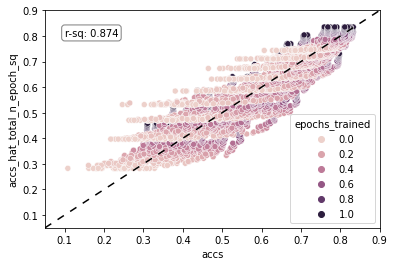

rsquare train:
0.8739319614542411
val avg loss:
0.002492201274909232


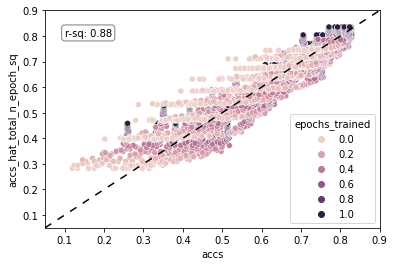

rsquare val:
0.8803284816709707


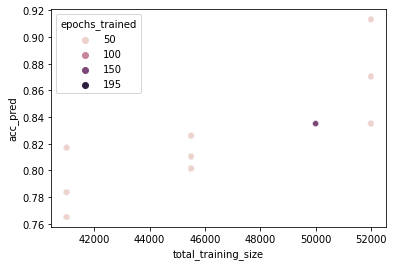

,training_times,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epochs_trained,total_training_size,acc_pred
0,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,195,50000.0,0.835150
1,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,150,50000.0,0.835150
2,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,195,45500.0,0.810544
3,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,150,45500.0,0.810544
4,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,100,45500.0,0.810544
5,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,50,45500.0,0.810544
6,100.0,4500.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,195,45500.0,0.826191
7,100.0,4500.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,150,45500.0,0.826191
8,100.0,4500.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,100,45500.0,0.826191
9,100.0,4500.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,50,45500.0,0.826191


In [22]:
def func_powerlaw(x, a: float, b: float, c: float, d_total_n:float, d_epochs:float, d_epochs_sq:float) -> float:
    x_total_n = x[0]
    x_epoch = x[1]
    return a + ((d_total_n * x_total_n + d_epochs*x_epoch + d_epochs_sq*x_epoch**2)**b) * c

np.random.seed(seed=959486)
p0 = np.random.uniform(low=0, high=1, size = 6)
converged = False
try:
    params, params_cov = curve_fit(func_powerlaw, xdata_total_n_epoch, y, maxfev=200000, p0=p0, bounds=(-10, 10))
    converged = True
except:
    print("did not converge")

if converged:
    param_names = ["a", "b", "c", "total_n", "epoch", "epoch_sq"]
    param_df = pd.DataFrame({"param_name": param_names, "param_value": params})
    param_df = param_df.set_index("param_name").T
    HTML(display(param_df))
    print(param_df.to_latex())
    y_hat = func_powerlaw(xdata_total_n_epoch, *params)
    print("train avg loss:")
    print(((y_hat - y)**2).mean())
    # dataframe for plotting:
    y_hat_name = "accs_hat_total_n_epoch_sq"
    results[y_hat_name] = y_hat
    sns.scatterplot(data = results, x="accs", y = y_hat_name, hue = "epochs_trained")
    plt.xlim((0.05, 0.9))
    plt.ylim((0.05, 0.9))
    plt.axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
    plt.text(x=0.1, y=0.8, s=f"r-sq: {np.round(metrics.r2_score(results.accs, results[y_hat_name]), 3)}", bbox=props)
    plt.savefig(f"paper/plots/powerlaw_train_{y_hat_name}.jpg")
    plt.show()
    print("rsquare train:")
    print(metrics.r2_score(results.accs, results[y_hat_name]))
    # val data:
    y_val_hat = func_powerlaw(xdata_val_total_n_epoch, *params)
    print("val avg loss:")
    print(((y_val_hat - y_val)**2).mean())
    # dataframe for plotting:
    results_val[y_hat_name] = y_val_hat

    sns.scatterplot(data = results_val, x="accs", y = y_hat_name, hue = "epochs_trained")
    plt.xlim((0.05, 0.9))
    plt.ylim((0.05, 0.9))
    plt.axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
    plt.text(x=0.1, y=0.8, s=f"r-sq: {np.round(metrics.r2_score(results_val.accs, results_val[y_hat_name]), 3)}", bbox=props)
    plt.savefig(f"paper/plots/powerlaw_val_{y_hat_name}.jpg")
    plt.show()
    print("rsquare val:")
    print(metrics.r2_score(results_val.accs, results_val[y_hat_name]))

    acc_pred = func_powerlaw(xpred, *params)
    results_pred_orig["acc_pred"] = acc_pred
    sns.scatterplot(data = results_pred_orig, x = "total_training_size", y = "acc_pred", hue="epochs_trained")
    plt.show()
    display(results_pred_orig.head(30))

### Using the arctan trick also for the total_n model:

param_name,a,b,c,total_n,total_n_2,epoch,epoch_2
param_value,0.187455,0.834989,0.459501,0.301866,10.0,1.176081,1.146217


\begin{tabular}{lrrrrrrr}
\toprule
param\_name &         a &         b &         c &   total\_n &  total\_n\_2 &     epoch &   epoch\_2 \\
\midrule
param\_value &  0.187455 &  0.834989 &  0.459501 &  0.301866 &       10.0 &  1.176081 &  1.146217 \\
\bottomrule
\end{tabular}

train avg loss:
0.0018922205167255998


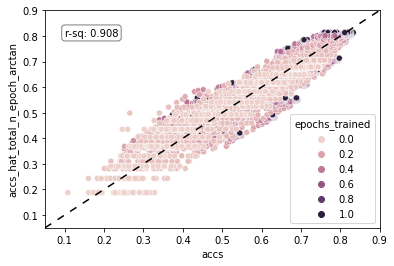

rsquare train:
0.9079985566035378
0.9079357386066811
val avg loss:
0.0017979388405832027


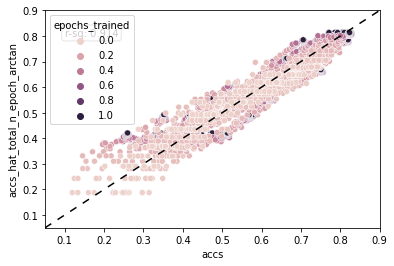

rsquare val:
0.9136658531228932
0.9135478642458648


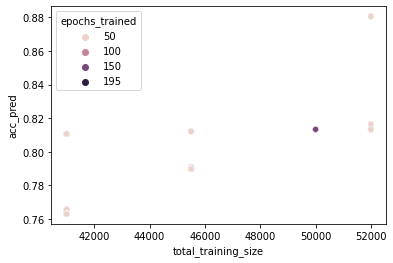

,training_times,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epochs_trained,total_training_size,acc_pred
0,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,195,50000.0,0.813349
1,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,150,50000.0,0.813349
2,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,195,45500.0,0.790981
3,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,150,45500.0,0.790981
4,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,100,45500.0,0.790981
5,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,50,45500.0,0.790981
6,100.0,4500.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,195,45500.0,0.812148
7,100.0,4500.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,150,45500.0,0.812148
8,100.0,4500.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,100,45500.0,0.812148
9,100.0,4500.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,50,45500.0,0.812148


In [23]:
def func_powerlaw(x, a: float, b: float, c: float, d_total_n:float, d_total_n_2:float, d_epochs:float, d_epochs_2:float) -> float:
    x_total_n = x[0]
    x_epoch = x[1]
    return a + ((d_total_n * np.arctan(d_total_n_2 * x_total_n) + d_epochs* np.arctan( d_epochs_2 * x_epoch))**b) * c

np.random.seed(seed=92548)
n_p = 7
p0 = np.random.uniform(low=0, high=1, size = n_p)
converged = False
try:
    params, params_cov = curve_fit(func_powerlaw, xdata_total_n_epoch, y, maxfev=200000, p0=p0, bounds=(-10, 10))
    converged = True
except:
    print("did not converge")

if converged:
    param_names = ["a", "b", "c", "total_n", "total_n_2", "epoch", "epoch_2"]
    param_df = pd.DataFrame({"param_name": param_names, "param_value": params})
    param_df = param_df.set_index("param_name").T
    HTML(display(param_df))
    print(param_df.to_latex())
    y_hat = func_powerlaw(xdata_total_n_epoch, *params)
    print("train avg loss:")
    print(((y_hat - y)**2).mean())
    # dataframe for plotting:
    y_hat_name = "accs_hat_total_n_epoch_arctan"
    results[y_hat_name] = y_hat
    sns.scatterplot(data = results, x="accs", y = y_hat_name, hue = "epochs_trained")
    plt.xlim((0.05, 0.9))
    plt.ylim((0.05, 0.9))
    plt.axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
    plt.text(x=0.1, y=0.8, s=f"r-sq: {np.round(metrics.r2_score(results.accs, results[y_hat_name]), 3)}", bbox=props)
    plt.savefig(f"paper/plots/powerlaw_train_{y_hat_name}.jpg")
    plt.show()
    print("rsquare train:")
    print(metrics.r2_score(results.accs, results[y_hat_name]))
    print(1 - (1 - metrics.r2_score(results.accs, results[y_hat_name])) * (xdata_total_n_epoch.shape[1] - 1) / (xdata_total_n_epoch.shape[1] - n_p - 1))
    # val data:
    y_val_hat = func_powerlaw(xdata_val_total_n_epoch, *params)
    print("val avg loss:")
    print(((y_val_hat - y_val)**2).mean())
    # dataframe for plotting:
    results_val[y_hat_name] = y_val_hat

    sns.scatterplot(data = results_val, x="accs", y = y_hat_name, hue = "epochs_trained")
    plt.xlim((0.05, 0.9))
    plt.ylim((0.05, 0.9))
    plt.axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
    plt.text(x=0.1, y=0.8, s=f"r-sq: {np.round(metrics.r2_score(results_val.accs, results_val[y_hat_name]), 3)}", bbox=props)
    plt.savefig(f"paper/plots/powerlaw_val_{y_hat_name}.jpg")
    plt.show()
    print("rsquare val:")
    print(metrics.r2_score(results_val.accs, results_val[y_hat_name]))
    print(1 - (1 - metrics.r2_score(results_val.accs, results_val[y_hat_name])) * (xdata_val.shape[1] - 1) / (xdata_val.shape[1] - n_p - 1))

    acc_pred = func_powerlaw(xpred, *params)
    results_pred_orig["acc_pred"] = acc_pred
    sns.scatterplot(data = results_pred_orig, x = "total_training_size", y = "acc_pred", hue="epochs_trained")
    plt.show()
    display(results_pred_orig.head(30))

# restricting to last epoch:

param_name,a,b,c,plane,car,bird,cat,deer,dog,frog,horse,ship,truck
param_value,0.137152,0.412225,0.368085,0.67315,0.507472,0.518125,0.249679,0.50874,0.458291,0.484901,0.611524,0.363008,0.418775


train avg loss:
0.0016495515062395095


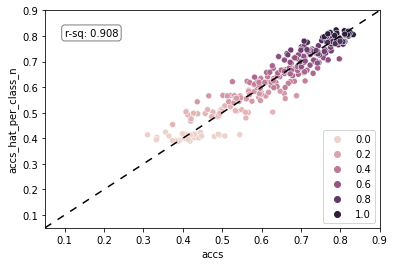

rsquare train:
0.9075660664700929
val avg loss:
0.0018398750329358274


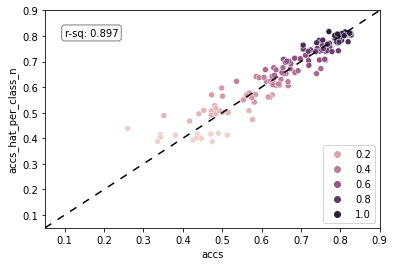

rsquare val:
0.897281335076856


In [24]:
def func_powerlaw(x, a: float, b: float, c: float, d0:float, d1:float, d2:float, d3:float, d4:float, d5:float, d6:float, d7:float, d8:float, d9:float) -> float:
    x0 = x[0]
    x1 = x[1]
    x2 = x[2]
    x3 = x[3]
    x4 = x[4]
    x5 = x[5]
    x6 = x[6]
    x7 = x[7]
    x8 = x[8]
    x9 = x[9]
    return a + ((d0*x0 + d1*x1 + d2*x2 + d3*x3 + d4*x4 + d5*x5 + d6*x6 + d7*x7 + d8*x8 + d9*x9)**b) * c


p0 = np.random.uniform(low=0, high=1, size = 13)
converged = False
try:
    params, params_cov = curve_fit(func_powerlaw, xdata_last_epoch, y_last_epoch, maxfev=200000, p0=p0, bounds=(-10, 10))
    converged = True
except:
    print("did not converge")

if converged:
    param_names = ["a", "b", "c"] + classes
    param_df = pd.DataFrame({"param_name": param_names, "param_value": params})
    param_df = param_df.set_index("param_name").T
    HTML(display(param_df))
    y_hat = func_powerlaw(xdata_last_epoch, *params)
    print("train avg loss:")
    print(((y_hat - y_last_epoch)**2).mean())
    # dataframe for plotting:
    y_hat_name = "accs_hat_per_class_n"
    results_last_epoch[y_hat_name] = y_hat
    sns.scatterplot(data = results_last_epoch, x="accs", y = y_hat_name, hue = "total_training_size")
    plt.legend(loc="lower right")
    plt.xlim((0.05, 0.9))
    plt.ylim((0.05, 0.9))
    plt.axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
    plt.text(x=0.1, y=0.8, s=f"r-sq: {np.round(metrics.r2_score(results_last_epoch.accs, results_last_epoch[y_hat_name]), 3)}", bbox=props)
    plt.show()
    print("rsquare train:")
    print(metrics.r2_score(results_last_epoch.accs, results_last_epoch[y_hat_name]))
    # val data:
    y_val_hat = func_powerlaw(xdata_val_last_epoch, *params)
    print("val avg loss:")
    print(((y_val_hat - y_val_last_epoch)**2).mean())
    # dataframe for plotting:
    results_val_last_epoch[y_hat_name] = y_val_hat

    sns.scatterplot(data = results_val_last_epoch, x="accs", y = y_hat_name, hue = "total_training_size")
    plt.xlim((0.05, 0.9))
    plt.ylim((0.05, 0.9))
    plt.axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
    plt.legend(loc="lower right")
    plt.text(x=0.1, y=0.8, s=f"r-sq: {np.round(metrics.r2_score(results_val_last_epoch.accs, results_val_last_epoch[y_hat_name]), 3)}", bbox=props)
    plt.show()
    print("rsquare val:")
    print(metrics.r2_score(results_val_last_epoch.accs, results_val_last_epoch[y_hat_name]))

# Fitting with total_n, only last epoch:

param_name,a,b,c
param_value,0.408111,0.704068,0.408313


train avg loss:
0.0018095482212022247


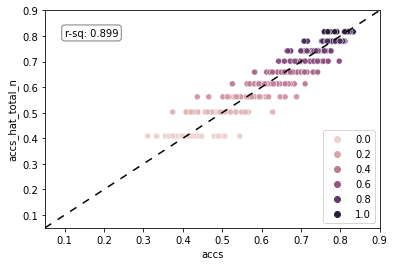

rsquare train:
0.8986005230118095
val avg loss:
0.0017054827561824746


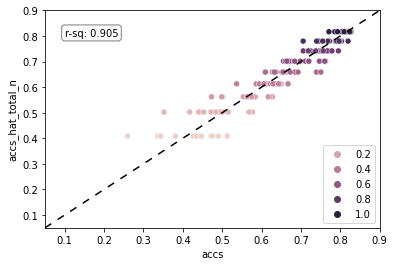

rsquare val:
0.9047843420729663


In [25]:
def func_powerlaw(x, a: float, b: float, c: float) -> float:
    x0 = x[0]
    return a + (x0**b) * c

p0 = np.random.uniform(low=0, high=1, size = 3)
converged = False
try:
    params, params_cov = curve_fit(func_powerlaw, xdata_last_epoch_total_n, y_last_epoch, maxfev=200000, p0=p0, bounds=(-10, 10))
    converged = True
except:
    print("did not converge")

if converged:
    param_names = ["a", "b", "c"]
    param_df = pd.DataFrame({"param_name": param_names, "param_value": params})
    param_df = param_df.set_index("param_name").T
    HTML(display(param_df))
    y_hat = func_powerlaw(xdata_last_epoch_total_n, *params)
    print("train avg loss:")
    print(((y_hat - y_last_epoch)**2).mean())
    # dataframe for plotting:
    y_hat_name = "accs_hat_total_n"
    results_last_epoch[y_hat_name] = y_hat
    sns.scatterplot(data = results_last_epoch, x="accs", y = y_hat_name, hue = "total_training_size")
    plt.xlim((0.05, 0.9))
    plt.ylim((0.05, 0.9))
    plt.axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
    plt.text(x=0.1, y=0.8, s=f"r-sq: {np.round(metrics.r2_score(results_last_epoch.accs, results_last_epoch[y_hat_name]), 3)}", bbox=props)
    plt.legend(loc="lower right")
    plt.show()
    print("rsquare train:")
    print(metrics.r2_score(results_last_epoch.accs, results_last_epoch[y_hat_name]))
    # val data:
    y_val_hat = func_powerlaw(xdata_val_last_epoch_total_n, *params)
    print("val avg loss:")
    print(((y_val_hat - y_val_last_epoch)**2).mean())
    # dataframe for plotting:
    results_val_last_epoch[y_hat_name] = y_val_hat

    sns.scatterplot(data = results_val_last_epoch, x="accs", y = y_hat_name, hue = "total_training_size")
    plt.xlim((0.05, 0.9))
    plt.ylim((0.05, 0.9))
    plt.axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
    plt.text(x=0.1, y=0.8, s=f"r-sq: {np.round(metrics.r2_score(results_val_last_epoch.accs, results_val_last_epoch[y_hat_name]), 3)}", bbox=props)
    plt.legend(loc="lower right")
    plt.show()
    print("rsquare val:")
    print(metrics.r2_score(results_val_last_epoch.accs, results_val_last_epoch[y_hat_name]))